# Background

The shape of outputs in integrated gradients suggests that IG may overestimate some attribution values due to saturated gradients at interpolated inputs. To confirm this, we run SplitIG (which cuts off the interpolated inputs if the gradients are saturated) and examine the level of agreement.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from split_ig import SplitLayerIntegratedGradients


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Set up Split IG

In [77]:
def compute_layer_to_output_attributions_split_ig(
    original_input, 
    layer_input, 
    layer_baseline, 
    target_layer, 
    prev_layer, 
    metric, 
    metric_labels, 
    ratio=1.0,
):
    n_steps = 200
    n_samples = original_input.size(0)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(model, original_input, prev_layer, x, metric, metric_labels)

    # Attribute to the target_layer's output
    split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions = split_ig.attribute(inputs=layer_input,
                                    baselines=layer_baseline,
                                    method="riemann_right",
                                    n_steps=n_steps,
                                    internal_batch_size=n_samples, # Needs to match patching shape
                                    attribute_to_layer_input=False,
                                    return_convergence_delta=False)
    grads, outputs, steps, interpolated_inputs = attributions

    # [n_samples, n_steps, seq_len, d_heads, d_model]
    grads = grads.reshape((-1, n_steps,) + grads.shape[1:])
    # [n_samples, n_steps]
    outputs = outputs.reshape((-1, n_steps))

    print(grads.shape, outputs.shape)

    # Sanity check: shape of output
    plt.plot(outputs[0].detach().cpu())
    plt.show()

    left_igs = torch.zeros((n_samples,) + grads.shape[2:])
    right_igs = torch.zeros((n_samples,)+ grads.shape[2:])
    threshold_indices = torch.zeros((n_samples,))

    for i in range(n_samples):
        sample_output = outputs[i] # Shape [n_steps]
        sample_grads = grads[i]

        print(sample_output.shape, sample_grads.shape)
        # Calculate threshold for split integrated gradients
        min_out, min_index = torch.min(sample_output, dim=0)
        max_out, max_index = torch.max(sample_output, dim=0)
        threshold = min_out + ratio * (max_out - min_out)
        print(f"Threshold value: {threshold}")

        if max_index < min_index:
            # Flip direction such that min_index < max_index
            sample_output = sample_output.flip(dims=(0,))
            sample_grads = sample_grads.flip(dims=(0,))

        mask = sample_output > threshold
        if torch.count_nonzero(mask) > 0:
            threshold_index = mask.int().argmax(dim=0)

            if max_index < min_index:
                threshold_indices[i] = n_steps - threshold_index
            else:
                threshold_indices[i] = threshold_index
        else:
            # No value is above threshold, take full IG
            threshold_index = n_steps
            threshold_indices[i] = threshold_index

        print(f"Threshold index: {threshold_indices[i]}")

        # Grads have already been scaled. Sum and multiply.
        left_igs[i] = sample_grads[i, :threshold_index].sum(dim=0) * (max_out - min_out)
        right_igs[i] = sample_grads[i, threshold_index:].sum(dim=0) * (max_out - min_out)

    return left_igs, right_igs, threshold_indices

In [61]:
def split_integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)

        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = left_ig.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        score = left_ig.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

# Split IG and IOI

In [16]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=1)

In [17]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([2.3827], device='cuda:0')
Corrupted logit difference: tensor([-2.3610], device='cuda:0')


torch.Size([1, 200, 18, 12, 768]) torch.Size([1, 200])


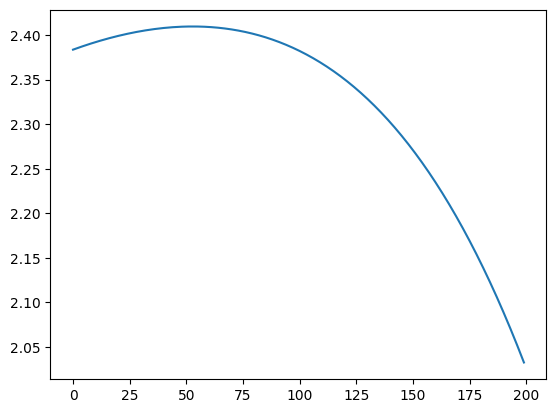

torch.Size([200]) torch.Size([200, 18, 12, 768])
Threshold value: 2.409632682800293
Threshold index: 200.0


UnboundLocalError: cannot access local variable 'threshold_index' where it is not associated with a value

In [76]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

# torch.save(ioi_split_ig_mlp, "saved_results/ioi_split_ig_mlp.pt")
# torch.save(ioi_split_ig_attn, "saved_results/ioi_split_ig_attn.pt")

In [ ]:
ioi_split_ig_mlp = torch.load("saved_results/ioi_split_ig_mlp.pt")
ioi_split_ig_attn = torch.load("saved_results/ioi_split_ig_attn.pt")

ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

ioi_ap_attn = ioi_ap_attn[0].unsqueeze(0)
ioi_ap_mlp = ioi_ap_mlp[0].unsqueeze(0)

In [48]:
ioi_split_ig_attn.shape

torch.Size([1, 12, 12])

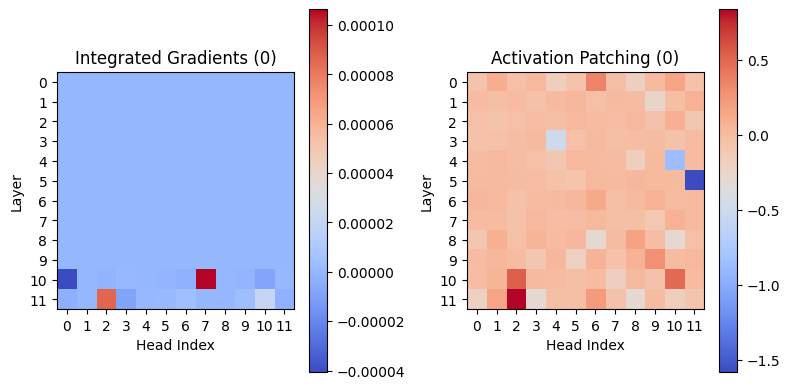

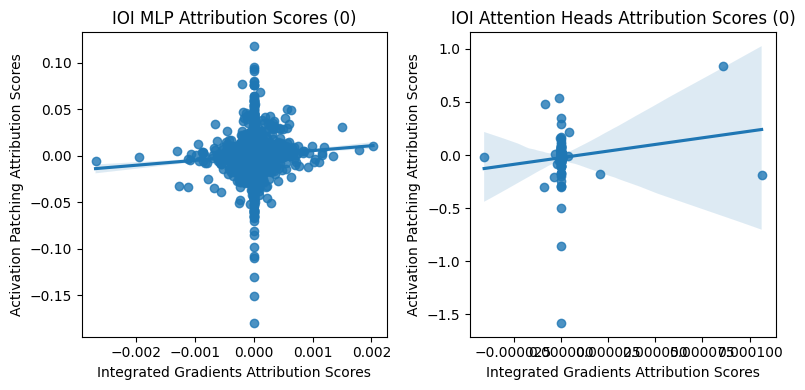

Correlation coefficient for neurons: 0.05010410979844291
Correlation coefficient for attention heads: 0.14958345882604127


In [49]:
plot_attn_comparison(ioi_split_ig_attn, ioi_ap_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, ioi_ap_mlp, ioi_split_ig_attn, ioi_ap_attn, Task.IOI)